<a href="https://colab.research.google.com/github/IvanTriandofilidi/Morse-code-recognition.-ASR/blob/main/Speech_recognation_Kontur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c morse-decoder -p /content/data

 98% 1.23G/1.25G [00:08<00:00, 217MB/s]
100% 1.25G/1.25G [00:08<00:00, 155MB/s]


In [ ]:
#data preparation
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import time

from glob import glob
import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os

# Предположим, ваш ZIP-файл называется 'my_archive.zip' и находится
# либо в корневой директории Colab, либо вы знаете его путь.

zip_file_path = '/content/data/morse-decoder.zip'  # Замените на фактический путь к вашему ZIP-файлу
extract_dir = 'extracted_files'  # Директория, куда будут извлечены файлы

# Создаем директорию для извлечения, если она не существует
os.makedirs(extract_dir, exist_ok=True)

# Используем команду 'unzip' для извлечения файлов
!unzip "{zip_file_path}" -d "{extract_dir}"

print(f"Файлы успешно извлечены в директорию: {extract_dir}")

# (Опционально) Проверьте содержимое извлеченной директории
!ls "{extract_dir}"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: extracted_files/morse_dataset/morse_dataset/5502.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5503.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5504.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5505.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5506.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5507.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5508.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5509.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/551.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5510.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5511.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5512.opus  
  inflating: extracted_files/morse_dataset/morse_dataset/5513.opus  
  inflating: extracted_files/morse_d

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

In [ ]:
#Переведем слова с символы
train['message'] = train['message']
train

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ
...,...,...
29995,29996.opus,ЬДТРЭ 9М6М
29996,29997.opus,ЬКТ1 ШЭЪ
29997,29998.opus,ЫВЙЗБЯН7К
29998,29999.opus,ФЯДШ3Т#


In [ ]:
#Формирование словаря для шифровки,зададим каждому символу по цифре.
#Получим количество символов в сообщении.
tt  = set()
for i in range(int(len(train))):
  message = train.iloc[i]['message']  # Получаем строку из DataFrame
  for ds in message:
    tt.update(ds)
vocablury = {}
tt = sorted(list(tt), reverse=True)
for u in range(len(tt)):
  vocablury[tt[u]]= u
print(vocablury)

{'Я': 0, 'Ю': 1, 'Э': 2, 'Ь': 3, 'Ы': 4, 'Ъ': 5, 'Щ': 6, 'Ш': 7, 'Ч': 8, 'Ц': 9, 'Х': 10, 'Ф': 11, 'У': 12, 'Т': 13, 'С': 14, 'Р': 15, 'П': 16, 'О': 17, 'Н': 18, 'М': 19, 'Л': 20, 'К': 21, 'Й': 22, 'И': 23, 'З': 24, 'Ж': 25, 'Е': 26, 'Д': 27, 'Г': 28, 'В': 29, 'Б': 30, 'А': 31, '9': 32, '8': 33, '7': 34, '6': 35, '5': 36, '4': 37, '3': 38, '2': 39, '1': 40, '0': 41, '#': 42, ' ': 43}


In [ ]:
#Формирование словаря для расшифровки,зададим каждому символу по цифре.
#Получим количество символов в сообщении.
kk  = set()
for i in range(int(len(train))):
  message = train.iloc[i]['message']  # Получаем строку из DataFrame
  for ds in message:
    kk.update(ds)
d_vocablury = {}
kk = sorted(list(kk), reverse=True)
for u in range(len(kk)):
  d_vocablury[u]= kk[u]
print(d_vocablury)

{0: 'Я', 1: 'Ю', 2: 'Э', 3: 'Ь', 4: 'Ы', 5: 'Ъ', 6: 'Щ', 7: 'Ш', 8: 'Ч', 9: 'Ц', 10: 'Х', 11: 'Ф', 12: 'У', 13: 'Т', 14: 'С', 15: 'Р', 16: 'П', 17: 'О', 18: 'Н', 19: 'М', 20: 'Л', 21: 'К', 22: 'Й', 23: 'И', 24: 'З', 25: 'Ж', 26: 'Е', 27: 'Д', 28: 'Г', 29: 'В', 30: 'Б', 31: 'А', 32: '9', 33: '8', 34: '7', 35: '6', 36: '5', 37: '4', 38: '3', 39: '2', 40: '1', 41: '0', 42: '#', 43: ' '}


In [ ]:
len(train)

30000

In [ ]:
len(test)

5000

In [ ]:
audio_files = glob('/content/extracted_files/morse_dataset/morse_dataset/*.opus')

In [ ]:
audio_files

['/content/extracted_files/morse_dataset/morse_dataset/2708.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/16255.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/26154.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/3537.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/23147.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/18974.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/9953.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/30035.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/3348.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/3210.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/34194.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/30197.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/29974.opus',
 '/content/extracted_files/morse_dataset/morse_dataset/25461.opus',
 '/content/extracted_files/morse_dataset/morse_datase

In [ ]:
len(audio_files)

35000

In [ ]:
import re
def extract_number(filename):
    """Извлекает число из имени файла."""
    match = re.search(r'(\d+)\.opus$', filename)
    if match:
        return int(match.group(1))
    return None

In [ ]:
sorted_audio_files = sorted(audio_files, key=extract_number)
sorted_audio_files[34999]

'/content/extracted_files/morse_dataset/morse_dataset/35000.opus'

In [ ]:
pd.set_option('display.max_colwidth', None) #Расширяет ширину видимого окна.
#Переформируем тренировочный и тестовый датасет
train['audio_path'] = sorted_audio_files[:30000]
test['audio_path'] = sorted_audio_files[30000:35000]
test = test.drop(['id'], axis=1)
train = train.drop(['id'], axis=1)

In [ ]:
train.shape

(30000, 2)

In [ ]:
def open_file(audio_file):
  samples, sample_rate = librosa.load(audio_file)
  return (samples, sample_rate)

In [ ]:
train.loc[1]['audio_path']

'/content/extracted_files/morse_dataset/morse_dataset/2.opus'

In [ ]:
fg = open_file(train.loc[0]['audio_path'])
fg

(array([ 5.7217962e-04,  4.3649194e-04,  1.9291276e-04, ...,
        -2.0326497e-01, -1.9311741e-01, -1.0869881e-01], dtype=float32),
 22050)

In [ ]:
#Пример аудиофайла.
ipd.Audio(audio_files[0])

In [ ]:
#Переходим к обработке файлов
def open_file(audio_file):
  samples, sample_rate = librosa.load(audio_file)
  return (samples, sample_rate)

In [ ]:
samples = open_file(audio_files[5000])
len(samples[0])
samples[0].reshape((1,176400))
samples[0].reshape((1,176400)).shape
samples[0].mean()
samples[0].std()
((samples[0]-samples[0].mean())/samples[0].std()).mean()

np.float32(-2.8220974e-09)

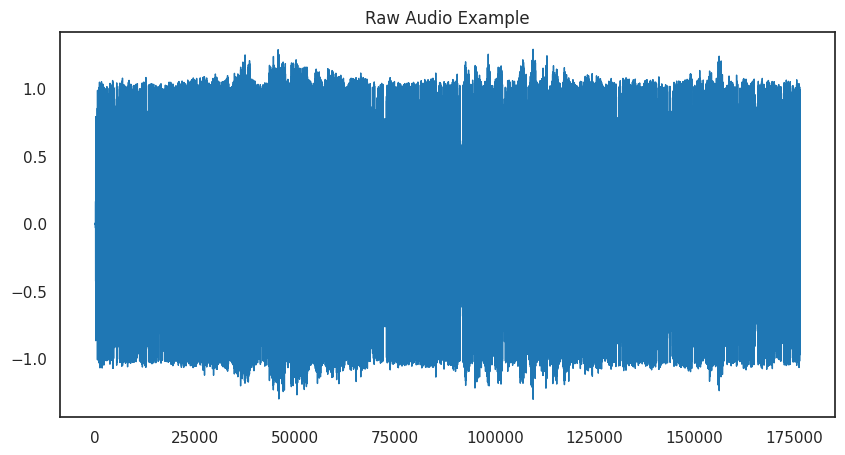

In [ ]:
#Построим для примера
samples = open_file(audio_files[0])

pd.Series(samples[0]).plot(figsize=(10, 5),
                        lw=1,
                        title='Raw Audio Example',
                        color=color_pal[0])
plt.show()

In [ ]:
#преобразуем в Mel-Spectrogram
def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
  samples, sample_rate = audio
  top_db = 80

  #from spectrogram to melspectrogram
  ml_sp = librosa.feature.melspectrogram(y=samples,
                                     sr=sample_rate,
                                     n_fft=n_fft,
                                     hop_length=hop_len,
                                     n_mels=n_mels)
  # Convert to decibels
  dml_sp = librosa.amplitude_to_db(ml_sp, ref = 80)  #ref = np.max
  return (dml_sp)


In [ ]:
ty = spectro_gram(samples)
dml_spect = torch.Tensor(ty).unsqueeze(0)
dml_spect.shape

torch.Size([1, 64, 690])

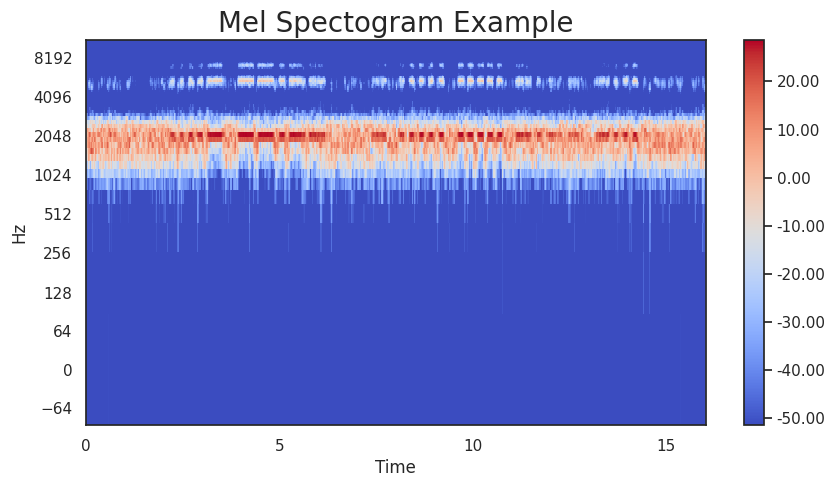

In [ ]:
ty = spectro_gram(samples)
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(ty,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
#Получили итерационно среднее значение и среднее квадратичное отклонение
mean_sample = -69.05112
std_sample = 18.674374

In [ ]:
#Преобразования для аудиозаписи.

class AudioUtil():
  #Загружаем аудиофайл
  @staticmethod
  def open_file(audio_file):
    samples, sample_rate = librosa.load(audio_file)
    return (samples, sample_rate)


  #преобразуем в Mel-Spectrogram
  @staticmethod
  def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
    samples, sample_rate = audio

  #from spectrogram to melspectrogram
    ml_sp = librosa.feature.melspectrogram(y=samples,
                                     sr=sample_rate,
                                     n_fft=n_fft,
                                     hop_length=hop_len,
                                     n_mels=n_mels)
  # Convert to decibels
    dml_spect = librosa.amplitude_to_db(ml_sp, ref = np.max)
    dml_spect = (dml_spect - mean_sample)/std_sample

  #Транспонируем, для правильной подачи данных
    dml_spect = torch.Tensor(dml_spect).unsqueeze(0)
    return dml_spect

  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec


  #Для преобразования message в числовой вид и обратно.
  @staticmethod
  def word2index(text):
    vocablury = {'Я': 0, 'Ю': 1, 'Э': 2, 'Ь': 3, 'Ы': 4, 'Ъ': 5, 'Щ': 6, 'Ш': 7, 'Ч': 8, 'Ц': 9, 'Х': 10,
                  'Ф': 11, 'У': 12, 'Т': 13, 'С': 14, 'Р': 15, 'П': 16, 'О': 17, 'Н': 18, 'М': 19, 'Л': 20,
                  'К': 21, 'Й': 22, 'И': 23, 'З': 24, 'Ж': 25, 'Е': 26, 'Д': 27, 'Г': 28, 'В': 29, 'Б': 30,
                  'А': 31, '9': 32, '8': 33, '7': 34, '6': 35, '5': 36, '4': 37, '3': 38, '2': 39, '1': 40,
                  '0': 41, '#': 42, ' ': 43, '<blank>': 44} #'blank'- Добавили специальный символ для CTC

    #Преобразуем слово в индексы
    indices = [vocablury[char] for char in text]

    return indices

  @staticmethod
  def index2word(text):
    vocab= {0: 'Я', 1: 'Ю', 2: 'Э', 3: 'Ь', 4: 'Ы', 5: 'Ъ', 6: 'Щ', 7: 'Ш', 8: 'Ч', 9: 'Ц',
     10: 'Х', 11: 'Ф', 12: 'У', 13: 'Т', 14: 'С', 15: 'Р', 16: 'П', 17: 'О', 18: 'Н',
     19: 'М', 20: 'Л', 21: 'К', 22: 'Й', 23: 'И', 24: 'З', 25: 'Ж', 26: 'Е', 27: 'Д',
     28: 'Г', 29: 'В', 30: 'Б', 31: 'А', 32: '9', 33: '8', 34: '7', 35: '6', 36: '5',
     37: '4', 38: '3', 39: '2', 40: '1', 41: '0', 42: '#', 43: ' ', 44: '<blank>'}

     #Преобразуем индексы в слова
    word = [vocab[char] for char in text]

    return word


#Создаем загрузчик данных.
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

class SoundDS(Dataset):
  def __init__(self, df):
    self.df = df

    #Кол-во экз-ров в датасете.
  def __len__(self):
    return len(self.df)

    #Находим элемент по индексу.
  def __getitem__(self, idx):
    audio_file = self.df.loc[idx, 'audio_path'] #Получим полный путь к аудиофайлу
    message = self.df.loc[idx, 'padding_message'] #Получим расшифровку аудиофайла
    message_len = self.df.loc[idx, 'message'] #Расшифровка, из которой получим длину
    aud = AudioUtil.open_file(audio_file)
    sp_gram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sp_gram = AudioUtil.spectro_augment(sp_gram, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1)
    input_lengths = np.array(sp_gram.shape[2]//33).reshape(1,)
    label_lengths = np.array(len(message_len)).reshape(1,)

    return aug_sp_gram, message, input_lengths, label_lengths


class Test_SoundDS(Dataset):
  def __init__(self, df):
    self.df = df

    #Кол-во экз-ров в датасете.
  def __len__(self):
    return len(self.df)

    #Находим элемент по индексу.
  def __getitem__(self, idx):
    audio_file = self.df.loc[idx, 'audio_path'] #Получим полный путь к аудиофайлу
    aud = AudioUtil.open_file(audio_file)
    sp_gram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    input_lengths = np.array(sp_gram.shape[2]//33).reshape(1,)

    return sp_gram, input_lengths


In [ ]:
#Добавим паддинг в датасет
ssf = ([torch.tensor((AudioUtil.word2index(i))) for i in train['message']])
padding_value = -1
g = torch.nn.utils.rnn.pad_sequence(ssf, batch_first=True, padding_value = padding_value)
asd = pd.DataFrame(g.numpy())
padding_messege = asd.apply(np.array, axis=1)
train['padding_message'] = padding_messege #получили паддинг транскрибции в датасете
tyt = torch.tensor(train['padding_message'])
tyt.shape

/tmp/ipython-input-4194742610.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  tyt = torch.tensor(train['padding_message'])


torch.Size([30000, 14])

In [ ]:
train

,message,audio_path,padding_message
0,03ЩУЫЛПИГХ,/content/extracted_files/morse_dataset/morse_dataset/1.opus,"[41, 38, 6, 12, 4, 20, 16, 23, 28, 10, -1, -1, -1, -1]"
1,ЪЛТ0ДС6А3Г,/content/extracted_files/morse_dataset/morse_dataset/2.opus,"[5, 20, 13, 41, 27, 14, 35, 31, 38, 28, -1, -1, -1, -1]"
2,5ЭКЫБЗХЯН,/content/extracted_files/morse_dataset/morse_dataset/3.opus,"[36, 2, 21, 4, 30, 24, 10, 0, 18, -1, -1, -1, -1, -1]"
3,ЖЫЦОИ68КФ,/content/extracted_files/morse_dataset/morse_dataset/4.opus,"[25, 4, 9, 17, 23, 35, 33, 21, 11, -1, -1, -1, -1, -1]"
4,32Ю7МЫ ЗЛ,/content/extracted_files/morse_dataset/morse_dataset/5.opus,"[38, 39, 1, 34, 19, 4, 43, 24, 20, -1, -1, -1, -1, -1]"
...,...,...,...
29995,ЬДТРЭ 9М6М,/content/extracted_files/morse_dataset/morse_dataset/29996.opus,"[3, 27, 13, 15, 2, 43, 32, 19, 35, 19, -1, -1, -1, -1]"
29996,ЬКТ1 ШЭЪ,/content/extracted_files/morse_dataset/morse_dataset/29997.opus,"[3, 21, 13, 40, 43, 7, 2, 5, -1, -1, -1, -1, -1, -1]"
29997,ЫВЙЗБЯН7К,/content/extracted_files/morse_dataset/morse_dataset/29998.opus,"[4, 29, 22, 24, 30, 0, 18, 34, 21, -1, -1, -1, -1, -1]"
29998,ФЯДШ3Т#,/content/extracted_files/morse_dataset/morse_dataset/29999.opus,"[11, 0, 27, 7, 38, 13, 42, -1, -1, -1, -1, -1, -1, -1]"


In [ ]:
test = test[0:4983]
test


,audio_path
0,/content/extracted_files/morse_dataset/morse_dataset/30001.opus
1,/content/extracted_files/morse_dataset/morse_dataset/30002.opus
2,/content/extracted_files/morse_dataset/morse_dataset/30003.opus
3,/content/extracted_files/morse_dataset/morse_dataset/30004.opus
4,/content/extracted_files/morse_dataset/morse_dataset/30005.opus
...,...
4978,/content/extracted_files/morse_dataset/morse_dataset/34979.opus
4979,/content/extracted_files/morse_dataset/morse_dataset/34980.opus
4980,/content/extracted_files/morse_dataset/morse_dataset/34981.opus
4981,/content/extracted_files/morse_dataset/morse_dataset/34982.opus


In [ ]:
#Подготовим пакет данных с помощью загрузчика данных.
#Разобьем обучающий набор данных на валидационную и тренировочную выборку, локальную тестовую выборку.
from torch.utils.data import random_split

my_ds = SoundDS(train)
test_ds = Test_SoundDS(test)
#Разделим датасет в соотношении 10:10:80 между валидационной и тренировочной, локальной тестовой выборкой
num_items = len(my_ds)
num_train = round(num_items*0.8)
num_val = round((num_items - num_train)/2)
num_local_test = num_items - num_train - num_val
train_ds, val_ds, local_test_ds  = random_split(my_ds, [num_train, num_val, num_local_test])

#Создадим загрузчик данных для тренировочной и валидационной выборки, локальной тестовой выборки.
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False, drop_last=True)
local_test_dl = torch.utils.data.DataLoader(local_test_ds, batch_size=16, shuffle=False, drop_last=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
len(local_test_dl)

187

In [ ]:
batch = next(iter(train_dl))
sp_gram, message, input_lengths, label_lengths = batch
message.shape
batch

[tensor([[[[-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           ...,
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863]]],
 
 
         [[[-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5220],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.4106],
           ...,
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863],
           [-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.5863]]],
 
 
         [[[-0.5863, -0.5863, -0.5863,  ..., -0.5863, -0.5863, -0.4550],
       

In [ ]:
batch = next(iter(test_dl))
sp_gram, input_lengths = batch
input_lengths.shape

torch.Size([16, 1])

In [ ]:
690//33

20

In [ ]:
#Создаем модель(CNN+RNN+CTC)
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
!pip install jiwer
from jiwer import cer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.6 MB/s eta 0:00:00


In [ ]:
class MorseCodebreaker (nn.Module):
  def __init__(self, num_classes):
    super(MorseCodebreaker, self).__init__()
    conv_layers = []

    #Первый сверточный слой. Иницилизируем веса, функция Relu, батч нормализация.
    self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3), stride=(2,3), padding=(2,2))
    self.bn1 = nn.BatchNorm2d(8)
    self.relu1 = nn.ReLU()
    init.kaiming_normal_(self.conv1.weight, a=0.1)
    self.conv1.bias.data.zero_()
    conv_layers +=[self.conv1, self.bn1, self.relu1]

    #Второй сверточный слой.
    self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,2), padding=(3,3))
    self.bn2 = nn.BatchNorm2d(16)
    self.relu2 = nn.ReLU()
    init.kaiming_normal_(self.conv2.weight, a=0.1)
    self.conv2.bias.data.zero_()
    conv_layers += [self.conv2,self.bn2, self.relu2]

    #Третий сверточный слой.
    self.conv3 = nn.Conv2d(16, 64, kernel_size=(3,3), stride=(2,3), padding=(3,3))
    self.bn3 = nn.BatchNorm2d(64)
    self.relu3 = nn.ReLU()
    self.AvgPool3 = nn.AvgPool2d(kernel_size=(2, 2))
    init.kaiming_normal_(self.conv3.weight, a=0.1)
    self.conv3.bias.data.zero_()
    conv_layers += [self.conv3, self.bn3, self.relu3, self.AvgPool3]


    #Обьеденим все слои
    self.conv_layers = nn.Sequential(*conv_layers) #получили на выходе  тензор (16, 64, 39, 23)

    self.fc_0 = nn.Linear(64*39, 256)
    self.relu_fc0 = nn.ReLU()


  def forward(self, x, h=None):

    conv_output = self.conv_layers(x)
    #batch_size = conv_output.size(0)
    # (Batch, Channels, Height, Width) -> (Batch, Width, Channels, Height)
    #conv_output_permuted = conv_output.permute(0, 3, 1, 2) # -> (16, 23, 64, 39)
    # Объединяем измерения Channels и Height в одно измерение Input Size
    # Используем contiguous() перед view() для гарантии правильного расположения в памяти
    #fo_input = conv_output_permuted.contiguous().view(batch_size, -1, 64*39)
    #fc_0 = self.fc_0(fo_input)
    #output = self.relu_fc0(fc_0)

    return conv_output

My_Model = MorseCodebreaker(num_classes=45)
My_Model = My_Model.to(device)

In [ ]:
input = torch.rand([16, 1, 64, 690]).to(device)
out = My_Model(input)

out.shape

torch.Size([16, 64, 10, 20])

In [ ]:
class MorseCodebreaker (nn.Module):
  def __init__(self, num_classes):
    super(MorseCodebreaker, self).__init__()
    conv_layers = []

    #Первый сверточный слой. Иницилизируем веса, функция Relu, батч нормализация.
    self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3), stride=(2,3), padding=(2,2))
    self.bn1 = nn.BatchNorm2d(8)
    self.relu1 = nn.ReLU()
    init.kaiming_normal_(self.conv1.weight, a=0.1)
    self.conv1.bias.data.zero_()
    conv_layers +=[self.conv1, self.bn1, self.relu1]

    #Второй сверточный слой.
    self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,2), padding=(3,3))
    self.bn2 = nn.BatchNorm2d(16)
    self.relu2 = nn.ReLU()
    init.kaiming_normal_(self.conv2.weight, a=0.1)
    self.conv2.bias.data.zero_()
    conv_layers += [self.conv2,self.bn2, self.relu2]

    #Третий сверточный слой.
    self.conv3 = nn.Conv2d(16, 64, kernel_size=(3,3), stride=(2,3), padding=(3,3))
    self.bn3 = nn.BatchNorm2d(64)
    self.relu3 = nn.ReLU()
    self.AvgPool3 = nn.AvgPool2d(kernel_size=(2, 2))
    init.kaiming_normal_(self.conv3.weight, a=0.1)
    self.conv3.bias.data.zero_()
    conv_layers += [self.conv3, self.bn3, self.relu3, self.AvgPool3]

    #Обьеденим все слои
    self.conv_layers = nn.Sequential(*conv_layers) #получили на выходе  тензор (16, 64, 10, 20)

    #Добавим слой-мост
    self.fc_0 = nn.Linear(64*10, 256)
    self.relu_fc0 = nn.ReLU()

    # LSTM блок. На вход должны подать преобразованный тензор (16, 20, 128)
    self.lstm = nn.LSTM(
        input_size=256,
        hidden_size=256,
        num_layers=5,
        dropout=0.5,
        batch_first=True,
        bidirectional=True
    )

    self.fc_01 = nn.Linear(2*256, 512)
    self.relu_fc01 = nn.ReLU()

    #Слой для алгоритма СТС
    self.fc_ctc = nn.Linear(512, num_classes) #1, так как LSTM однонаправленная, 2 - в случае двухнаправленной

  def init_hidden(self, batch_size):
    h_0 = torch.zeros(self.lstm.num_layers * (2 if self.lstm.bidirectional else 1), batch_size, self.lstm.hidden_size).to(device)
    c_0 = torch.zeros(self.lstm.num_layers * (2 if self.lstm.bidirectional else 1), batch_size, self.lstm.hidden_size).to(device)
    return h_0, c_0

  def forward(self, x, h=None):

    conv_output = self.conv_layers(x)
    batch_size = conv_output.size(0)
    # (Batch, Channels, Height, Width) -> (Batch, Width, Channels, Height)
    conv_output_permuted = conv_output.permute(0, 3, 1, 2) # -> (16, 20, 64, 10)
    # Объединяем измерения Channels и Height в одно измерение Input Size
    # Используем contiguous() перед view() для гарантии правильного расположения в памяти
    fo_input = conv_output_permuted.contiguous().view(batch_size, -1, 64*10)

    fc_0 = self.fc_0(fo_input)
    relu_fc0 = self.relu_fc0(fc_0)

    if h is None:
       h_0, c_0 = self.init_hidden(batch_size)
    else:
       h_0, c_0 = h # Используем переданные скрытые состояния

    # LSTM ожидает вход в виде (input, (h_0, c_0))
    lstm_output, (h_n, c_n) = self.lstm(relu_fc0, (h_0, c_0))

    # lstm_output размерность: (Batch Size, Sequence Length, num_directions * hidden_size)
    #                          -> (16, 21, 2 * 256 = 512)
    # h_n, c_n размерность: (num_layers * num_directions, Batch Size, hidden_size)
    #                      -> (2 * 2, 16, 256) -> (4, 16, 256)
    # 5.Пропускаем выход LSTM через линейный слой для получения логитов для CTC
    # Линейный слой обрабатывает последнее измерение (размер признаков на каждом шаге)

    #lstm_relu = self.lstm_relu(lstm_output)

    fc_01 = self.fc_01(lstm_output)
    relu_fc01 = self.relu_fc01(fc_01)

    ctc_output = self.fc_ctc(relu_fc01) # Не Берем последний временной шаг для каждого шага (1 вариант)
    # ctc_output размерность: (Batch Size, Sequence Length, num_classes) -> (16, 21, num_classes)
    # 6. Возвращаем выход модели и конечные скрытые состояния
    # Конечные скрытые состояния могут быть использованы для следующего батча,
    # если вы тренируете stateful RNN, или просто игнорируются.
    return ctc_output

My_Model = MorseCodebreaker(num_classes=45)
My_Model = My_Model.to(device)

In [ ]:
model = MorseCodebreaker(num_classes=45)

# Подсчет параметров
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {num_params}")

Количество обучаемых параметров: 7821053


In [ ]:
print(model)

MorseCodebreaker(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 3), padding=(2, 2))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 2), padding=(3, 3))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 3), padding=(3, 3))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (AvgPool3): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 3), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 2), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [ ]:
#Обучение модели.
def train(model, num_epochs, train_dl, val_dl, clip, lr, batch_size): #best_loss=None, threshold=0.01):
  #Зададим функцию потерь, оптимизатор, планировщик
  criterion = nn.CTCLoss(blank=44, zero_infinity=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                  steps_per_epoch=int(len(train_dl)),
                                                  epochs=num_epochs,
                                                  anneal_strategy='linear')
  train_data_len = len(train_dl.dataset)
  valid_data_len = len(val_dl.dataset)
  epoch_train_loss = 0
  epoch_val_loss = 0
  train_losses = []
  valid_losses = []

#Start training
  model.train()

  for e in range(num_epochs):
    t0 = time.time()
    h = model.init_hidden(batch_size)

    #batch loop
    running_loss = 0.0

    for batch_inx, _data in enumerate(train_dl, 1):       #enumerate считает индекс каждого итерируемого батча,#1 означает, что расчет с 1
      specs, labels, input_lengths, label_lengths = _data
      specs, labels = specs.to(device), labels.to(device)
  #Создаем новый тензор, который не требует вычисления градиента,нужно чтобы отсоеденить историю обучения скрытого состояния
  #от предыдущих элементов батча

      #print('Смотрим, что такое h')
      #print(h[0])
      #print(h[0].min() == 0)

      h = tuple(s.detach() for s in h)
      #h = h.detach()
      #Обнуляем градиенты
      model.zero_grad()
      #Получим выход модели
      output  = model(specs, h)

      output = F.log_softmax(output, dim=2)
      output = output.transpose(0,1)
      #Подсчет потерь и backpropo
      loss = criterion(output, labels, input_lengths, label_lengths)
      loss.backward()
      # clip_grad_norm
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()
      scheduler.step()
      # loss stats
      running_loss += loss.item() * specs.size(0)

    t_t = time.time() - t0

#Валидация модели

    with torch.no_grad():
      model.eval()
      tv = time.time()
      running_val_loss = 0.0
      for batch_idx_v, _data in enumerate(val_dl, 1):
        specs, labels, input_lengths, label_lengths = _data
        specs, labels = specs.to(device), labels.to(device)
        val_h = model.init_hidden(batch_size)
        output = model(specs, val_h)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0,1)
        val_loss = criterion(output, labels, input_lengths, label_lengths)
        running_val_loss += val_loss.item()*specs.size(0)

      print("Epoch {}: Training took {:.2f} [s]\tValidation took: {:.2f} [s]\n".format(e+1, t_t, time.time() - tv))


    epoch_train_loss = running_loss / train_data_len
    epoch_val_loss = running_val_loss / valid_data_len
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)

    print('Epoch: {} Losses\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(e+1, epoch_train_loss, epoch_val_loss))

    model.train()

    print('==============================================================================')
    print('Epoch {} took total {} seconds'.format(e+1, time.time() - t0))
    print('==============================================================================')

#Сохранение модели.
    #if best_loss is None:
      #best_loss = epoch_val_loss

    #if best_loss - epoch_val_loss > threshold and e > 10:
      #best_loss = epoch_val_loss

  torch.save(model.state_dict(), f'Audio_model_state_dict_epoch_{e+1}.pt')
  print(f'На эпохе - {e+1}, сохранена модель со значением функции потерь на валидации - {epoch_val_loss:.6f}', end='\n\n')

  return (model, train_losses, valid_losses)


In [ ]:
model, train_losses, valid_losses = train(model=My_Model,num_epochs=10, train_dl= train_dl, val_dl = val_dl, clip=5, lr=1e-3, batch_size=16)

Epoch 1: Training took 2902.71 [s]	Validation took: 278.75 [s]

Epoch: 1 Losses	Training Loss: 4.093121	Validation Loss: 3.984910
Epoch 1 took total 3181.457098007202 seconds
Epoch 2: Training took 2892.32 [s]	Validation took: 271.95 [s]

Epoch: 2 Losses	Training Loss: 3.989317	Validation Loss: 3.963831
Epoch 2 took total 3164.274707555771 seconds
Epoch 3: Training took 2862.01 [s]	Validation took: 272.53 [s]

Epoch: 3 Losses	Training Loss: 3.941617	Validation Loss: 3.867945
Epoch 3 took total 3134.5395007133484 seconds
Epoch 4: Training took 2855.73 [s]	Validation took: 267.75 [s]

Epoch: 4 Losses	Training Loss: 3.865739	Validation Loss: 3.813140
Epoch 4 took total 3123.4866194725037 seconds
Epoch 5: Training took 2888.61 [s]	Validation took: 269.91 [s]

Epoch: 5 Losses	Training Loss: 3.774783	Validation Loss: 3.625616
Epoch 5 took total 3158.520934343338 seconds
Epoch 6: Training took 2854.59 [s]	Validation took: 268.43 [s]

Epoch: 6 Losses	Training Loss: 3.576736	Validation Loss: 3.

In [ ]:
#Часть 2. Дообучение модели.
param_model = torch.load('/content/epoch60.pt')
new_model = MorseCodebreaker(num_classes=45)
new_model.load_state_dict(param_model)


<All keys matched successfully>

In [ ]:
model, train_losses, valid_losses = train(model=new_model,num_epochs=10, train_dl= train_dl, val_dl = val_dl, clip=5, lr=1e-3, batch_size=16)

Epoch 1: Training took 2674.92 [s]	Validation took: 260.97 [s]

Epoch: 1 Losses	Training Loss: 0.859171	Validation Loss: 0.678085
Epoch 1 took total 2935.887563228607 seconds
Epoch 2: Training took 2639.65 [s]	Validation took: 257.17 [s]

Epoch: 2 Losses	Training Loss: 0.896202	Validation Loss: 0.731403
Epoch 2 took total 2896.829209089279 seconds
Epoch 3: Training took 2649.05 [s]	Validation took: 258.30 [s]

Epoch: 3 Losses	Training Loss: 0.941701	Validation Loss: 0.781175
Epoch 3 took total 2907.341887950897 seconds
Epoch 4: Training took 2660.25 [s]	Validation took: 254.46 [s]

Epoch: 4 Losses	Training Loss: 0.963873	Validation Loss: 0.801868
Epoch 4 took total 2914.7048287391663 seconds
Epoch 5: Training took 2645.61 [s]	Validation took: 258.58 [s]

Epoch: 5 Losses	Training Loss: 0.937236	Validation Loss: 0.775005
Epoch 5 took total 2904.1846108436584 seconds
Epoch 6: Training took 2652.34 [s]	Validation took: 257.02 [s]

Epoch: 6 Losses	Training Loss: 0.896996	Validation Loss: 0.

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_index = 44):
        batch_size, seq_len, _ = output.shape
        predicted_indices = torch.argmax(output, dim=2)  # (batch_size, seq_len)
        decoded_preds_indices = []
        decoded_targets_indices = []

        for i in range(batch_size):
            # Декодирование предсказанной последовательности (индексы)
            pred_sequence_indices = []
            last_index = -1
            for j in range(seq_len):
                current_index = predicted_indices[i, j].item()
                if (current_index != blank_index and len(pred_sequence_indices) == 0) or (current_index != blank_index and current_index != pred_sequence_indices[-1]):
                    pred_sequence_indices.append(current_index)
            decoded_preds_indices.append(pred_sequence_indices)

            # Декодирование целевой последовательности (индексы)
            target_sequence_indices = labels[i, :label_lengths[i]].tolist()
            decoded_targets_indices.append(target_sequence_indices)

        # Преобразование индексов в символы
        decoded_preds_symbols = ["".join(AudioUtil.index2word(seq)) for seq in decoded_preds_indices]
        decoded_targets_symbols = ["".join(AudioUtil.index2word(seq)) for seq in decoded_targets_indices]

        return decoded_preds_symbols, decoded_targets_symbols

In [ ]:
batch = next(iter(train_dl))
sp_gram, message, input_lengths, label_lengths = batch
output = torch.rand([16, 87, 45])
labels = message
label_lengths = label_lengths
decoderovanie,m = GreedyDecoder(output, labels,label_lengths,blank_index = 44)
decoderovanie,m

(['ЩЙТ271РГЮ7ЧЯЪЮ 4ДЙУ0ИЩЛЩЮСП0ЬА#АЯ1Ы3И6ЙЩЧЭГСЩУПТИСЕЪГДТЯКИФСЭНРОЫЦЪ2# ВЦЙФ2ЧВ9ТДЫП',
  'ЭТ72КН6Ч2ЭП14Щ6ФДКХГ92ВЛП6БГ8БЕЦ3ЦЯЦОГЬ9ГЦП0Х4ХФ3Ш#Ж 6ЭИЦЬ8ЭМ43ВУ8Б 5О5УСЮ9САЖЮГ2',
  '8Д2ГШ4ЪБ16ПА9Д90ШОЧА 6#ЩРВЬЛЙ5Э32ЫБ186БВ04ЦДКГБ#ШЧФЮЧЯЫХЖ6МБСЙЮ6ВЩМ4О2ЬЙЯ3КЖНЩ1ЗН',
  '64Д06ШЗДЛ6ОУ6П6С И 76К6ЦПМ8СНХМП0ОХЦХУРЛАЫ ЗКЙК Д8Х5ГЬО18ЖЩЫТШ7СЭФ8Ф0704Л5СИЦЩЖ#1Я4ЩЧ',
  'ГЧ4Р9Ь0ЩСБЗПМ ПЮВКЩЮЪСРДВИФ0МЕЯДЪУШТНЩНИЮЩД7ЮИ9Я9Я8УЭЪУХЛО5ВЕУ4З#3ЖЦГДЧЦРМЭМЛЩ2СР',
  'ЕА5ЮЪУ2ЪШГАДА98ЙПИЗЩЭТЩЮ Т3Ц#ФТ9ИХП23УВФВЩЭ0ШЭ1ЫЩХШЕЮМ9СЯСЙМ2Т39БЕЬ4ЗА08#2ЫЪХЕ7А ЗПЧ3Щ',
  'БО8ЛЫЗУ ЕЯ2ЮЭШЭЯМ6РФ1Й9НПАШН6ЮИ6Е2ЭМОЙ#ВЖ1ЙЬБ37Г9Э 8ИДЦНМПЦБ4ЩГВ17ВАЗ242ПШЬЖЦ1ЗЙЮ7ВЫ',
  'ЩЭГМУСЛИЦД19К1ПУ50УЦКМЖПТЧБ ЯСЖ3ФЕНУМТУ8ИАЛА5УВ931Ф3А12Б4296О32 Ь37ЪБТДЬЧЭН5#МДЛЬЕ32',
  'ФЗЖБ5БОФТ9ЫАНЬЩ7Г5ЯГ8ЙЭХЦЕВЩТЙЧ#ШЧЛКЦА9ЕЪ56ЗЕ 0ЛЧЬБХК1ГАДНЖБР0ЛЪЦЭГЛМХ ЯШЭ8ГЯФЮИХС',
  'СНШЯЗЬШ3Л57Д6ШПУШ40АЬ23ЩВЬ7#А#Ч3БЭВ ВЫЪХ4Ш06ЮЭБ1И6Х9Д7Л3РГЦ26ОЧ 2ЗКЙРЬ0ПУ8АЗ ЫПЪЫВС',
  ' ЯФЛЪШМК7МЪШЗУ #Р0БЪГХЛМЛЫЯЗНМЪЭФХМ54Ц825ВКТФПУТЮЭЩА Г6Ч 5ДР9Ч4З2В1Ю2Ч5ЫАЬ3ЬОГ0БЬ3Т',
  '1 АИ ЪЙЛШАЯС1Ы5Б3Ю 

In [ ]:
s = 'ИЭХУАХЦЧФ ОЩФ#2ЦГ2НЦС8ЛЖЮЦЖЪУ6Щ7Э6ЮЗЖ20ТВТЬМЭЩЦС4ЗНВЪШ0ЗУН7МКЛВШЙХ9ИЪГ27Б6ОИЫ#ЖИ'
print(len(s))

80


In [ ]:
#Тестируем модель
def test_model(model, local_test_dl, batch_size):
  criterion = nn.CTCLoss(blank=44, zero_infinity=True)
  model.eval()
  print('==================================================')
  test_cer = []
  test_loss = 0.0
  h = model.init_hidden(batch_size)
  with torch.no_grad():
    for batch_idx, _data in enumerate(local_test_dl, 1):
      specs, labels, input_lengths, label_lengths  = _data
      specs, labels = specs.to(device), labels.to(device)
      output = model(specs, h)
      output = output.transpose(0,1) #(time, batch, n_class)
      loss = criterion(output, labels, input_lengths, label_lengths)
      #Input should be [batch, seq_len, n_classes]
      output = output.transpose(1,0)
      (decoded_preds, decoded_targets) = GreedyDecoder(output, labels, label_lengths)
      test_loss += loss.item()* specs.size(0)
      #print(test_loss.item())
      for j in range(len(decoded_preds)):
        print('****************************************************************************')
        print('Predicted  {}'.format(decoded_preds[j]))
        print('Utterance  {}\n\n'.format(decoded_targets[j]))
        test_cer.append(cer(decoded_targets[j], decoded_preds[j]))

  avg_cer = sum(test_cer)/len(test_cer)

  print('Test set:Average CER: {:4f}'.format(avg_cer))

In [ ]:
Test_result = test_model(new_model, local_test_dl, batch_size=16 )

****************************************************************************
Predicted  ТЭ6СМУВС О
Utterance  ТЭ6СЫУВС О


****************************************************************************
Predicted  Я В9ЫСЯГ5У
Utterance  Я В9ЫСЯГГ5У


****************************************************************************
Predicted  ЦЬ519 9Й
Utterance  ЦК519 92Г


****************************************************************************
Predicted  ЯН Н4ЦК9
Utterance  КЯН Н4ЦК9


****************************************************************************
Predicted  8Х7Я #ФС4 И
Utterance  8ХЩЯ #ФСЛ И


****************************************************************************
Predicted  Д5УЗЖСОЯ0
Utterance  Л5УЗЖСОЯ0


****************************************************************************
Predicted  К30Ъ М4ЬН
Utterance  ЗР2Ъ М4ЬН


****************************************************************************
Predicted  МРЬЩГЙЗ2Я
Utterance  МР6ЩГЙЗ2Я


*************************

KeyboardInterrupt: 

In [ ]:
def GreedyDecoder2(output,blank_index = 44):
        batch_size, seq_len, _ = output.shape
        predicted_indices = torch.argmax(output, dim=2)  # (batch_size, seq_len)
        decoded_preds_indices = []

        for i in range(batch_size):
            # Декодирование предсказанной последовательности (индексы)
            pred_sequence_indices = []
            last_index = -1
            for j in range(seq_len):
                current_index = predicted_indices[i, j].item()
                if (current_index != blank_index and len(pred_sequence_indices) == 0) or (current_index != blank_index and current_index != pred_sequence_indices[-1]):
                    pred_sequence_indices.append(current_index)
            decoded_preds_indices.append(pred_sequence_indices)

        # Преобразование индексов в символы
        decoded_preds_symbols = ["".join(AudioUtil.index2word(seq)) for seq in decoded_preds_indices]


        return decoded_preds_symbols

In [ ]:
len(test_dl.dataset)

4983

In [ ]:
#Тестируем на практике.
def test(model, test_dl, batch_size):
  #criterion = nn.CTCLoss(blank=44, zero_infinity=True)
  model.eval()
  print('==================================================')
  h = model.init_hidden(batch_size)
  with torch.no_grad():
    for batch_idx, _data in enumerate(test_dl, 1):
      specs, input_lengths  = _data
      specs = specs.to(device)
      output = model(specs, h)
      decoded_preds = GreedyDecoder2(output)

      for j in range(len(decoded_preds)):
        print('****************************************************************************')
        print('Predicted  {}'.format(decoded_preds[j]))

In [ ]:
Test = test(new_model, test_dl, batch_size=16 )

Выходные данные были обрезаны до нескольких последних строк (5000).
****************************************************************************
Predicted  1Ф1ПБГК
****************************************************************************
Predicted  Э ШЭ З0ЬШ
****************************************************************************
Predicted  ЫЕ620ВЗЬИ8
****************************************************************************
Predicted  46ЩЭ6ЪЛ3
****************************************************************************
Predicted  Ч ИУ Л 2О
****************************************************************************
Predicted  ЯИКДВ08Ф Л
****************************************************************************
Predicted  8Х2ЬЕИЧГ
****************************************************************************
Predicted  Э93АН2Ч
****************************************************************************
Predicted  2ТЭРГН 9
*******************************************************

In [ ]:
#Переведем в excel-file
def test2(model, test_dl, batch_size):
  #criterion = nn.CTCLoss(blank=44, zero_infinity=True)
  message = []
  id = []
  model.eval()
  h = model.init_hidden(batch_size)
  with torch.no_grad():
    for batch_idx, _data in enumerate(test_dl, 1):
      specs, input_lengths  = _data
      specs = specs.to(device)
      output = model(specs, h)
      decoded_preds = GreedyDecoder2(output)

      for j in range(len(decoded_preds)):
        message.append(decoded_preds[j])

    for u in range(1, 5001):
      id.append('{number}.opus'.format(number= 30000 + u))

  return id, message

In [ ]:
id, message = test2(new_model, test_dl, batch_size=16 )

In [ ]:
adding = ['o' for i in range(24)]
message += adding
len(message)

5000

In [ ]:
len(id)

5000

In [ ]:
len(message)

5000

In [ ]:
dt = pd.DataFrame({'id':id, 'message':message})

In [ ]:
dt.head()

,id,message
0,30001.opus,ЯЮ6ЛИТЖФШ
1,30002.opus,КЩ В9Ю 9
2,30003.opus,Ы65Ф61Я
3,30004.opus,ЖНЖ9ИЫНЦ3
4,30005.opus,ЕЯФ4ЮЧЬ


In [ ]:
dt.to_csv('answer.csv', index=False, encoding='utf-8-sig')

NameError: name 'train_losses' is not defined

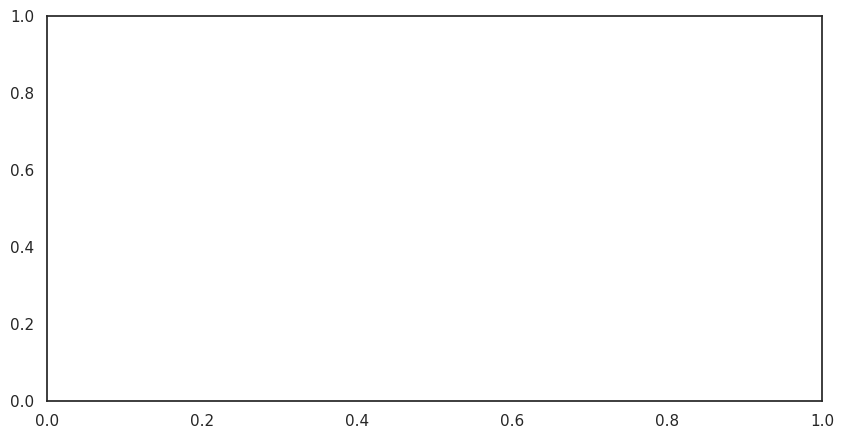

In [ ]:
#Построим график потерь валидационной и тренировочной выборки.
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
box = ax.get_position()

ax.plot(train_losses, 'g',label='Model-train  losses')
ax.plot(valid_losses, 'm',label='Model-valid losses')

plt.xlabel('epochs')
plt.ylabel('loss')

ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend above current axis
ax.legend(loc='upper center',fontsize='small', bbox_to_anchor=(0.5, 1.09),
          fancybox=True, shadow=True, ncol=4)
# Limits for the Y axis
plt.show()

In [ ]:
#Создадаим словарь с данными для последующего схранения.
checkpoint = {
    'state_model': My_Model.state_dict(),
    'state_optimizer': optimizer.state_dict(),
    'state_scheduler': scheduler.state_dict(),
    'loss': {
        'train_loss': epoch_train_loss,
        'valid_loss': epoch_val_loss,
        'best_loss': best_loss
    },
    'epoch' : e
}

NameError: name 'optimizer' is not defined

In [ ]:
#Вычислим итерационно среднее значение и квадратное отклонение для последующей нормализации.
all_samples = []
for file in train_dl:
   sp_gram, message, input_lengths, label_lengths = file
   all_samples.append(sp_gram)

all_samples = np.concatenate(all_samples)
print(all_samples.mean())
print(all_samples[0:10000].std())

mean_sample = -69.05112
std_sample = 18.674374

KeyboardInterrupt: 